In [15]:
import torch
import math
import h5py
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision import transforms as v2
from tqdm import tqdm

### resources 
this test is aimmed at the idea that we don't have time/resources to train large amounts of data therefore I am trying to get the benefits from the amazing encoding abilities of the transformers with the ability of CNN to work with small data sizes
<br>
https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb
<br>
https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/train.py
<br>
https://www.kaggle.com/code/shivamguptakaggle/uwmgi-smp-unet-2-5d-train
<br>
https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch#Dice-Loss
<br>
https://www.kaggle.com/code/nithishl025/brain-tumor-segmentation#Define-loss-function-and-metrics

In [2]:
# files paths 
paths = pd.read_csv('/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/meta_data.csv')

def add_root(value):
    root = '/kaggle/input/brats2020-training-data/BraTS2020_training_data'
    return root + value
paths['slice_path'] = paths['slice_path'].apply(lambda x: add_root(x))
paths.head(5)

,slice_path,target,volume,slice
0,/kaggle/input/brats2020-training-data/BraTS202...,0,41,0
1,/kaggle/input/brats2020-training-data/BraTS202...,0,41,1
2,/kaggle/input/brats2020-training-data/BraTS202...,0,41,2
3,/kaggle/input/brats2020-training-data/BraTS202...,0,41,3
4,/kaggle/input/brats2020-training-data/BraTS202...,0,41,4


In [3]:
print(paths['slice_path'][0])

/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_41_slice_0.h5


In [4]:
class brainSS(Dataset):
    def __init__(self, file_path, transform=None, augment=False):
        self.file_path = file_path
        self.transform = transform
        self.compact = True
        self.augment = augment
        self.file_path = self.filter_black_images(self.file_path)
    
    def __len__(self):
        return len(self.file_path)
    
    def __getitem__(self, idx):
        def convert_to_three_channels(image):
            combined_channel = np.maximum(image[0, :, :], image[1, :, :])
            new_image = np.stack([image[0, :, :], image[1, :, :], combined_channel], axis=0)
            return torch.tensor(new_image, dtype=torch.float32)
        
        def convert_to_one_channel(mask):
            combined_channels = np.maximum.reduce(mask, axis=0).unsqueeze(0)
            return torch.tensor(combined_channels, dtype=torch.long)
        
        def elastic_transform(image, mask, alpha_affine):
            random_state = np.random.RandomState(None)
            shape = image.shape
            shape_size = shape[:2]

            center_square = np.float32(shape_size) // 2
            square_size = 42
            pts1 = np.float32([center_square + square_size, 
                               [center_square[0] + square_size, center_square[1] - square_size], 
                               center_square - square_size])
            pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
            M = cv2.getAffineTransform(pts1, pts2)
            image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
            mask = cv2.warpAffine(mask, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
            return image, mask

        def hflip_transform(image, mask):
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)
            return image, mask

        def vflip_transform(image, mask):
            image = cv2.flip(image, 0)
            mask = cv2.flip(mask, 0)
            return image, mask

        def flip_transform(image, mask):
            image = cv2.flip(image, -1)
            mask = cv2.flip(mask, -1)
            return image, mask
        
        directory = self.file_path[idx]
        with h5py.File(directory, 'r') as f:
            image = f['image'][:]
            mask = f['mask'][:]
            
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))

            for i in range(image.shape[0]):
                min_val = np.min(image[i])
                image[i] = image[i] - min_val
                max_val = np.max(image[i]) + 1e-4
                image[i] = image[i] / max_val

            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)
        
        if self.augment:
            alpha_affine = image.shape[1] * 0.04
            aug_functions = [
                lambda img, msk: elastic_transform(img, msk, alpha_affine),
                hflip_transform,
                vflip_transform,
                flip_transform
            ]
            aug_function = np.random.choice(aug_functions)
            image, mask = aug_function(image.numpy(), mask.numpy())
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)
        
        sample = {'image': image, 'mask': mask}
        
        if self.compact:
            sample['image'] = convert_to_three_channels(sample['image'])
            sample['mask'] = convert_to_one_channel(sample['mask'])
            if self.transform:
                sample['image'] = self.transform['transform_3'](sample['image'])
                sample['mask'] = self.transform['transform_1'](sample['mask'])
        else:
            if self.transform:
                sample['image'] = self.transform['transform_4'](sample['image'])
                sample['mask'] = self.transform['transform_3'](sample['mask'])

        return sample
    
    def filter_black_images(self, file_paths):
        valid_file_paths = []
        for path in tqdm(file_paths, desc="Filtering black images"):
            with h5py.File(path, 'r') as f:
                image = f['image'][:]
                if np.max(image) > 0:
                    valid_file_paths.append(path)
        return valid_file_paths


In [5]:
# transformers for 4-channels
transform_4 = v2.Compose([
    v2.Resize((224, 224), antialias=True)
])

# transformers for 3-channels
transform_3 = v2.Compose([
    v2.Resize((224, 224), antialias=True),
    v2.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)
])

# transformers for 1-channel
transform_1 = v2.Compose([
    v2.Resize((224, 224), antialias=True)
])

transform = {'transform_1': transform_1, 'transform_3': transform_3, 'transform_4': transform_4}

In [6]:
# Data splitting
# Split data into 80% train and 20% temporary (val + test)
train_data, temp_data = train_test_split(paths['slice_path'], test_size=0.1, random_state=7)

# Split the temporary data into 50% validation and 50% test (which is 10% of the original data each)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=7)

train_data = train_data.to_list()
val_data = val_data.to_list()
test_data = test_data.to_list()

print(f"Train: {len(train_data)} samples")
print(f"Validation: {len(val_data)} samples")
print(f"Test: {len(test_data)} samples")

Train: 51475 samples
Validation: 2860 samples
Test: 2860 samples


In [7]:
# Create datasets
train_dataset = brainSS(train_data, transform=transform, augment=True)
val_dataset = brainSS(val_data, transform=transform, augment=False)
test_dataset = brainSS(test_data, transform=transform, augment=False)

# Print the number of filtered images
print(f"Filtered Train: {len(train_dataset)} samples")
print(f"Filtered Validation: {len(val_dataset)} samples")
print(f"Filtered Test: {len(test_dataset)} samples")

Filtering black images: 100%|██████████| 2860/2860 [00:49<00:00, 58.36it/s]

Filtered Train: 45817 samples
Filtered Validation: 2539 samples
Filtered Test: 2543 samples


In [18]:
# Create DataLoaders
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)


In [19]:
#test dataloaders
for sample in train_loader:
    print('Train image shape ' , sample['image'].shape , ', mask shape ' , sample['mask'].squeeze(1).shape)
    break
    
for sample in val_loader:
    print('Validation image shape ' , sample['image'].shape , ', mask shape ' , sample['mask'].squeeze(1).shape)
    break
for sample in test_loader:
    print('Test image shape ' , sample['image'].shape , ', mask shape ' , sample['mask'].squeeze(1).shape)
    break

/tmp/ipykernel_34/206485959.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(combined_channels, dtype=torch.long)


Train image shape  torch.Size([8, 3, 224, 224]) , mask shape  torch.Size([8, 224, 224])
Validation image shape  torch.Size([8, 3, 224, 224]) , mask shape  torch.Size([8, 224, 224])
Test image shape  torch.Size([1, 3, 224, 224]) , mask shape  torch.Size([1, 224, 224])


In [20]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows

def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H // window_size[0], W // window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x

def get_relative_position_index(win_h: int, win_w: int):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid(torch.arange(win_h), torch.arange(win_w),indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # shift to start from 0
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

class WindowAttention(nn.Module):
    def __init__(
            self,
            dim,
            window_size,
    ):
        super().__init__()
        self.window_size = window_size
        self.window_area = self.window_size[0]*self.window_size[1]
        self.num_heads = 4
        head_dim =  dim // self.num_heads
        # attn_dim = head_dim * self.num_heads
        self.scale = head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) **2, self.num_heads))

        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(self.window_size[0], self.window_size[1]), persistent=False)

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(self.window_area, self.window_area, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x, mask = None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)


        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + self._get_rel_pos_bias()
        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(-1, num_win, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        attn = self.softmax(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        return x

In [21]:
class SwinTransformerBlock(nn.Module):
    def __init__(
            self,  dim, input_resolution, window_size = 7, shift_size = 0):

        super().__init__()
        self.input_resolution = input_resolution
        window_size = (window_size, window_size)
        shift_size = (shift_size, shift_size)
        self.window_size = window_size
        self.shift_size = shift_size
        self.window_area = self.window_size[0] * self.window_size[1]

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
        )

        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.LayerNorm(4 * dim),
            nn.Linear( 4 * dim, dim)
        )

        if self.shift_size:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            H = math.ceil(H / self.window_size[0]) * self.window_size[0]
            W = math.ceil(W / self.window_size[1]) * self.window_size[1]
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            cnt = 0
            for h in (
                    slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None)):
                for w in (
                        slice(0, -self.window_size[1]),
                        slice(-self.window_size[1], -self.shift_size[1]),
                        slice(-self.shift_size[1], None)):
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_area)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask, persistent=False)

    def _attn(self, x):
        B, H, W, C = x.shape

        # cyclic shift
        if self.shift_size:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_area, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        shifted_x = shifted_x[:, :H, :W, :].contiguous()

        # reverse cyclic shift
        if self.shift_size:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=(1, 2))
        else:
            x = shifted_x
        return x

    def forward(self, x):
        B, H, W, C = x.shape
        B, H, W, C = x.shape
        x = x + self._attn(self.norm1(x))
        x = x.reshape(B, -1, C)
        x = x + self.mlp(self.norm2(x))
        x = x.reshape(B, H,W, C)
        return x

In [22]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_ch, num_feat, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(in_ch,num_feat, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).permute(0,2,3,1)

class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 2, 2, C//4)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*2, W*2 , C//4)

        x = self.norm(x)
        return x

class FinalPatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.expand = nn.Linear(dim, 16*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 4, 4, C//16)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*4, W*4 , C//16)

        x = self.norm(x)
        return x

In [23]:
class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size = 3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block,patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res, num_blocks=3):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand,swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features,self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x


class SwinUNet(nn.Module):
    def __init__(self, H, W, ch, C, num_class, num_blocks=3, patch_size = 4):
        super().__init__()
        self.patch_embed = PatchEmbedding(ch, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.bottleneck = SwinBlock(C*(2**num_blocks), (H//(patch_size* (2**num_blocks)), W//(patch_size* (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size),num_blocks)
        self.final_expansion = FinalPatchExpansion(C)
        self.head        = nn.Conv2d(C, num_class, 1,padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x,skip_ftrs  = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0,3,1,2))

        return x

In [24]:
criterion = nn.CrossEntropyLoss()

# Initialize your model, optimizer, and other necessary components
model = SwinUNet(224,224,3,8,3,3,4)#(H,W,channels,Batches,classes,blocks,patch_size)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
model.to(DEVICE)


cuda


SwinUNet(
  (patch_embed): PatchEmbedding(
    (conv): Conv2d(3, 8, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Encoder(
    (enc_swin_blocks): ModuleList(
      (0): SwinBlock(
        (swtb1): SwinTransformerBlock(
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=8, out_features=24, bias=True)
            (proj): Linear(in_features=8, out_features=8, bias=True)
            (softmax): Softmax(dim=-1)
          )
          (norm2): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (0): Linear(in_features=8, out_features=32, bias=True)
            (1): GELU(approximate='none')
            (2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
            (3): Linear(in_features=32, out_features=8, bias=True)
          )
        )
        (swtb2): SwinTransformerBlock(
          (norm1): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  

In [25]:

model_weights = torch.load('/kaggle/input/swin-unet-epoch-2/swin-unet_weights_epoch_2.pth')

# Load the weights into the model
model.load_state_dict(model_weights)

print("Weights Loaded Successfully!")

Weights Loaded Successfully!


In [34]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1, device='cuda'):
    model = model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            images = data['image'].to(device)
            masks = data['mask'].squeeze(1).long().to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()


            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}"):
                images = data['image'].to(device)
                masks = data['mask'].squeeze(1).long().to(device)



                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, masks)

                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss}")

    print("Training complete")


In [35]:
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)

Training Epoch 1/3:   0%|          | 0/5728 [00:00<?, ?it/s]/tmp/ipykernel_34/206485959.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(combined_channels, dtype=torch.long)
Training Epoch 1/3: 100%|██████████| 5728/5728 [27:29<00:00,  3.47it/s]


Epoch 1/3, Loss: 0.011305025412255611


Validation Epoch 1/3: 100%|██████████| 318/318 [01:21<00:00,  3.91it/s]


Validation Loss: 0.01258229462169228


Training Epoch 2/3: 100%|██████████| 5728/5728 [27:03<00:00,  3.53it/s]


Epoch 2/3, Loss: 0.010746121543996847


Validation Epoch 2/3: 100%|██████████| 318/318 [01:20<00:00,  3.94it/s]


Validation Loss: 0.0125420761844524


Training Epoch 3/3: 100%|██████████| 5728/5728 [26:21<00:00,  3.62it/s]


Epoch 3/3, Loss: 0.010152406529203432


Validation Epoch 3/3: 100%|██████████| 318/318 [01:17<00:00,  4.10it/s]

Validation Loss: 0.011747236809848497
Training complete


In [36]:
torch.save(model.state_dict(), '/kaggle/working/swin-unet_epoch_6.pth')
print("Weights Saving done!")

Weights Saving done!


In [37]:

model_weights = torch.load('/kaggle/working/swin-unet_epoch_6.pth')

# Load the weights into the model
model.load_state_dict(model_weights)

print("Weights Loaded Successfully!")

Weights Loaded Successfully!


In [42]:
def calculate_miou(mask, seg_pred):
    mask = mask.cpu().numpy()
    seg_pred = seg_pred.cpu().numpy()
    batch_size = mask.shape[0]
    
    iou_list = []
    for i in range(batch_size):
        intersection = np.logical_and(mask[i], seg_pred[i])
        union = np.logical_or(mask[i], seg_pred[i])

        if np.sum(union) == 0:
            iou = 1.0 if np.sum(intersection) == 0 else 0.0
        else:
            iou = np.sum(intersection) / np.sum(union)
        iou_list.append(iou)
    
    return iou_list


In [43]:
def calculate_dice_loss(mask, seg_pred):
    mask = mask.cpu().numpy()
    seg_pred = seg_pred.cpu().numpy()
    batch_size = mask.shape[0]

    dice_list = []
    for i in range(batch_size):
        intersection = np.sum(mask[i] * seg_pred[i])
        dice = 1 - ((2. * intersection + 1e-6) / (np.sum(mask[i]) + np.sum(seg_pred[i]) + 1e-6))
        dice_list.append(dice)
    
    return dice_list

In [44]:
# Function to calculate other metrics: accuracy, precision, recall, F1
def calculate_metrics(pred_seg, mask):
    pred_seg_bool = pred_seg.bool()
    mask_bool = mask.bool()
    
    TP = torch.logical_and(pred_seg_bool, mask_bool).float().sum()
    TN = torch.logical_and(~pred_seg_bool, ~mask_bool).float().sum()
    FP = torch.logical_and(pred_seg_bool, ~mask_bool).float().sum()
    FN = torch.logical_and(~pred_seg_bool, mask_bool).float().sum()
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    F1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, F1

In [53]:
def eval_plot(pred_seg,mask):
    for i in range(5):
        fig, axs = plt.subplots(1, 5)
        axs[0].imshow(img[i,0,:,:],cmap='magma')
        axs[1].imshow(img[i,1,:,:],cmap='magma')
        axs[2].imshow(img[i,2,:,:],cmap='magma')
        axs[3].imshow(mask[i],cmap='magma')
        axs[4].imshow(pred_seg[i],cmap='magma')
    plt.show()

/tmp/ipykernel_34/206485959.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(combined_channels, dtype=torch.long)


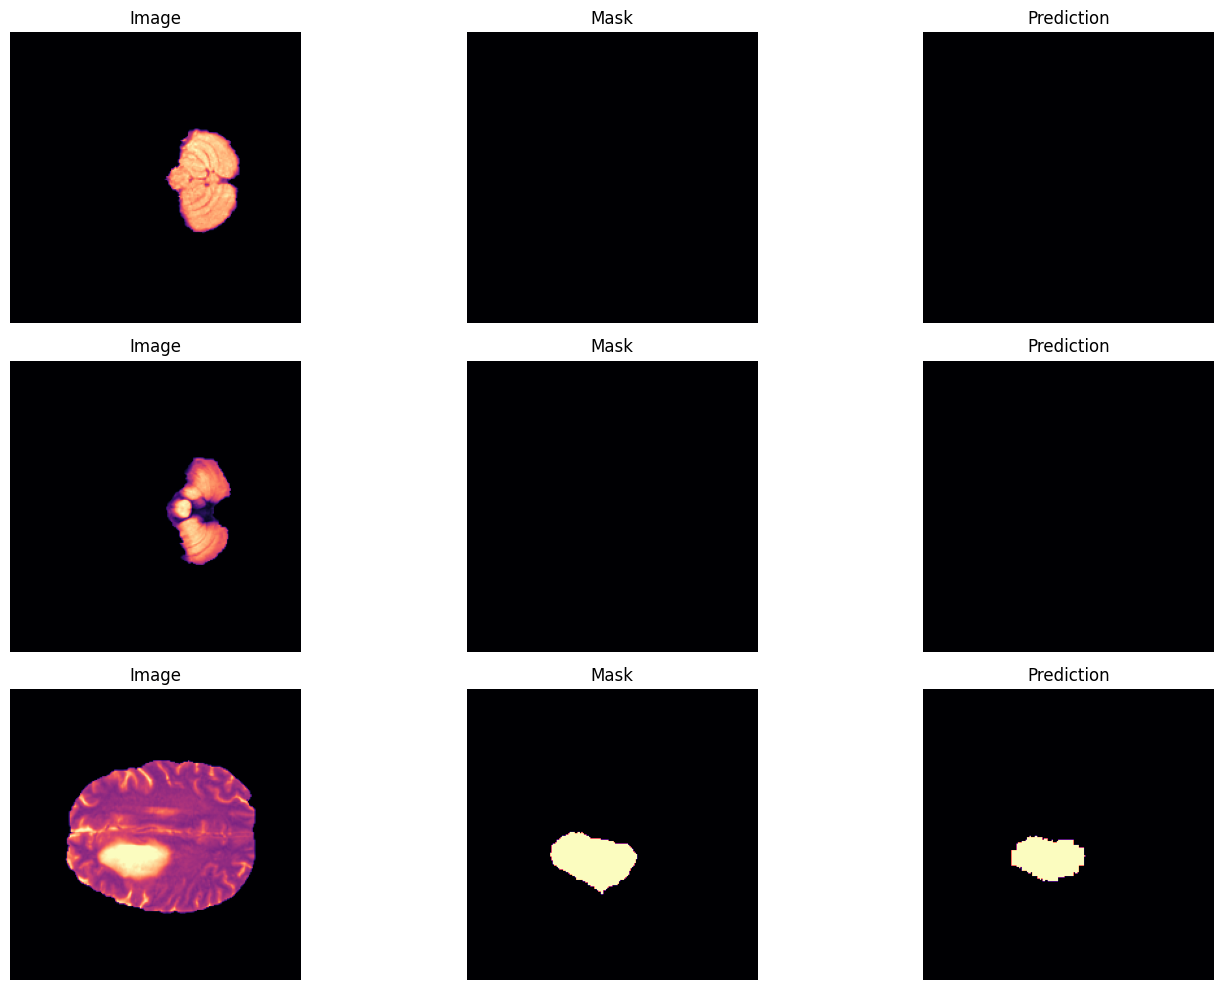

In [39]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)

fig, ax = plt.subplots(3, 3, figsize=(15, 10))

with torch.no_grad():
    for i in range(3):
        # Get a batch of training data
        batch = next(iter(train_loader))
        x_og, y_og = batch['image'], batch['mask']

        # Move the batch to the appropriate device
        x_og = x_og.to(DEVICE)
        
        # Get the model's prediction
        out = model(x_og)
        
        # Apply softmax to the model's output if using CrossEntropyLoss
        out = F.softmax(out, dim=1)
        
        # Get the predicted class
        out = torch.argmax(out, dim=1).cpu().numpy()  # Get the predicted class
        
        for j in range(x_og.shape[0]):
            # Move images and masks to CPU and convert to numpy for visualization
            x = x_og[j].cpu().numpy().transpose((1, 2, 0))  # Move to CPU and transpose for plotting
            y = y_og[j].cpu().numpy().squeeze()  # Move to CPU and squeeze to remove channel dimension
            
            # Plot the original image
            ax[i, 0].imshow(x[:, :, 0], cmap='magma')  # Display the first channel (assuming it's grayscale)
            ax[i, 0].set_title('Image')
            ax[i, 0].axis('off')
            
            # Plot the ground truth mask
            ax[i, 1].imshow(y, cmap='magma')
            ax[i, 1].set_title('Mask')
            ax[i, 1].axis('off')
            
            # Plot the prediction
            pred = out[j]
            ax[i, 2].imshow(pred, cmap='magma')
            ax[i, 2].set_title('Prediction')
            ax[i, 2].axis('off')
            

plt.tight_layout()
plt.show()


/tmp/ipykernel_34/206485959.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(combined_channels, dtype=torch.long)


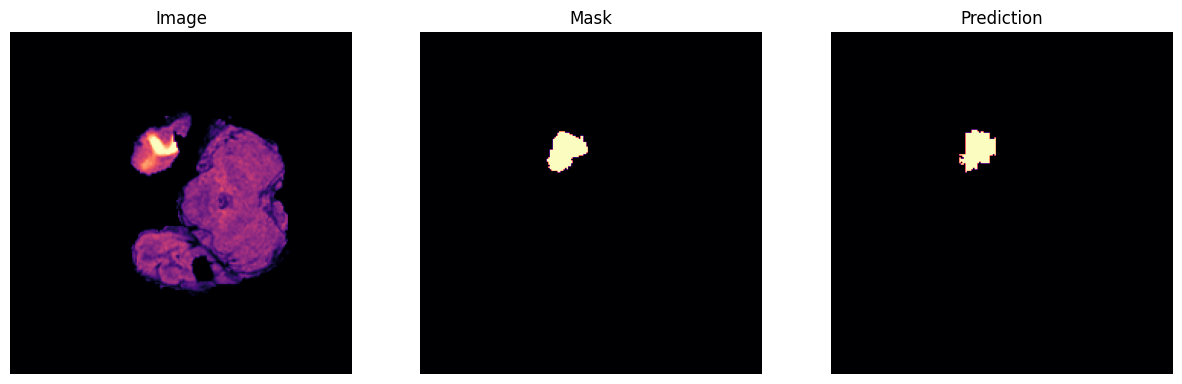

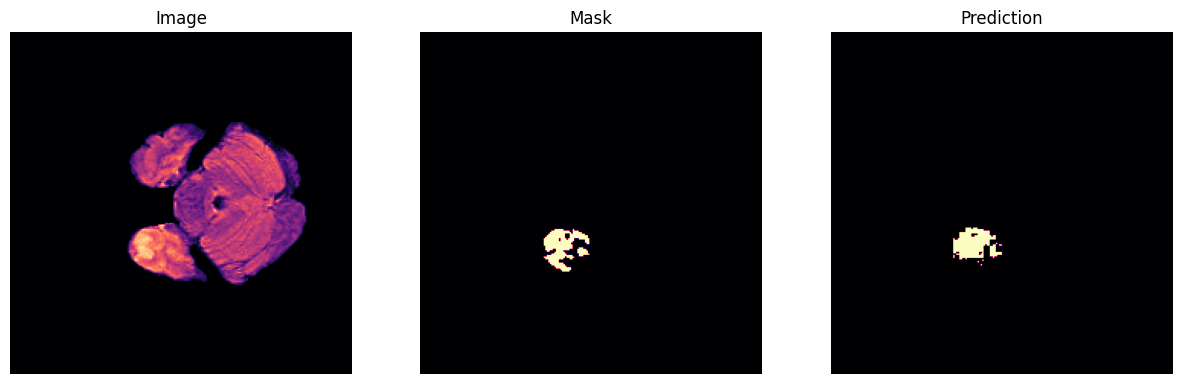

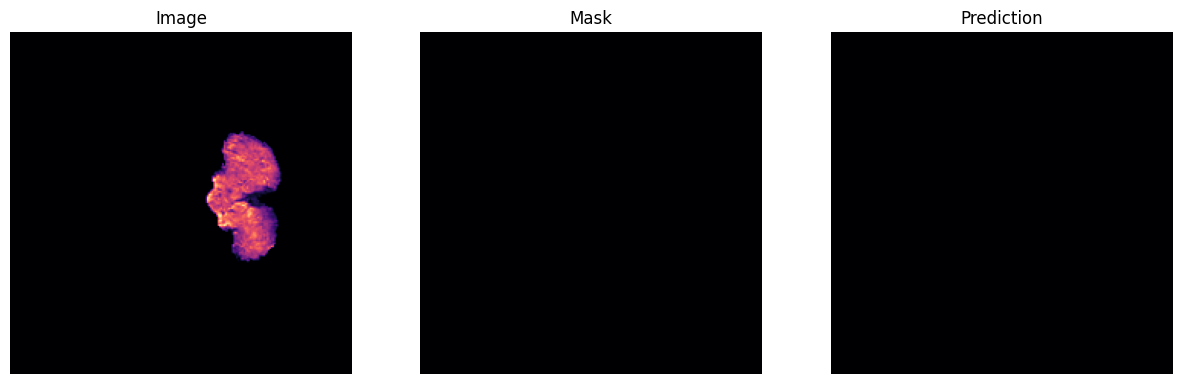

Average metrics over all test data:
Average mIoU: 0.7458125307298927
Average Dice Loss: 0.21309285523911137
Average Accuracy: 0.9955975100415643
Average Precision: 0.33018216490745544
Average Recall: 0.31692200899124146
Average F1 Score: 0.3075520098209381


In [58]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(DEVICE)
model.eval()  # Set model to evaluation mode

# Initialize lists to store metric values
miou_list = []
dice_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Create the test loader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

with torch.no_grad():
    for iteration, batch in enumerate(test_loader):
        # Get a batch of test data
        x_og, y_og = batch['image'], batch['mask']

        # Move images and masks to the appropriate device
        x_og = x_og.to(DEVICE)
        y_og = y_og.to(DEVICE)
        
        # Get the model's prediction
        out = model(x_og)
        
        # Apply softmax to the model's output if using CrossEntropyLoss
        out = F.softmax(out, dim=1)
        
        # Get the predicted class
        pred_seg = torch.argmax(out, dim=1)
        
        # Compute metrics
        miou = calculate_miou(y_og, pred_seg)
        dice = calculate_dice_loss(y_og, pred_seg)
        accuracy, precision, recall, f1 = calculate_metrics(pred_seg, y_og)
        
        # Append metrics to lists
        miou_list.extend(miou)
        dice_list.extend(dice)
        accuracy_list.append(accuracy.item())
        precision_list.append(precision)  # No need to call item()
        recall_list.append(recall)        # No need to call item()
        f1_list.append(f1)                # No need to call item()

        # Plotting for visualization (first 3 iterations)
        if iteration < 3:
            fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            x = x_og[0].cpu().numpy().transpose((1, 2, 0))  # Move to CPU and transpose for plotting
            y = y_og[0].cpu().numpy().squeeze()  # Move to CPU and squeeze to remove channel dimension
            pred = pred_seg[0].cpu().numpy().squeeze()  # Move to CPU and squeeze to remove channel dimension

            ax[0].imshow(x[:, :, 0], cmap='magma')  # Display the first channel (assuming it's grayscale)
            ax[0].set_title('Image')
            ax[0].axis('off')

            ax[1].imshow(y, cmap='magma')
            ax[1].set_title('Mask')
            ax[1].axis('off')

            ax[2].imshow(pred, cmap='magma')
            ax[2].set_title('Prediction')
            ax[2].axis('off')

            plt.show()

# Compute averages of the metrics
avg_miou = sum(miou_list) / len(miou_list)
avg_dice = sum(dice_list) / len(dice_list)
avg_accuracy = sum(accuracy_list) / len(accuracy_list)
avg_precision = sum(precision_list) / len(precision_list)
avg_recall = sum(recall_list) / len(recall_list)
avg_f1 = sum(f1_list) / len(f1_list)

print('Average metrics over all test data:')
print(f'Average mIoU: {avg_miou}')
print(f'Average Dice Loss: {avg_dice}')
print(f'Average Accuracy: {avg_accuracy}')
print(f'Average Precision: {avg_precision}')
print(f'Average Recall: {avg_recall}')
print(f'Average F1 Score: {avg_f1}')
